# 导入库

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
from collections import deque
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math
from torch.optim import lr_scheduler
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import copy

# 加载数据

In [2]:
# 1. 加载和预处理数据
data = pd.read_csv('D:\helloworld\VT1\data\keypoints2.csv')
X = data.drop('label', axis=1).values
y = data['label'].values


In [3]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [4]:
X

array([[0.93388152, 0.78938367, 0.92981653, ..., 0.9276406 , 0.58331999,
        0.88718399],
       [0.94525129, 0.79481047, 0.94289053, ..., 0.92345961, 0.58209952,
        0.8807991 ],
       [0.95304569, 0.79293109, 0.94833042, ..., 0.92306028, 0.58154152,
        0.88030847],
       ...,
       [0.01078312, 0.26391562, 0.17474516, ..., 0.5414239 , 0.40837272,
        0.49730566],
       [0.00619659, 0.26097199, 0.16970664, ..., 0.54589843, 0.40690443,
        0.5004999 ],
       [0.06663486, 0.31096485, 0.20290592, ..., 0.54300267, 0.40485625,
        0.50085526]])

In [5]:
# 标签编码
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [6]:
# 设置每个序列的长度
seq_length = 8


In [7]:
# num_samples, seq_length, num_features

num_samples = len(X) // seq_length
num_features = X.shape[1]
X_reshaped = X[:num_samples * seq_length].reshape((num_samples, seq_length, num_features))


In [8]:
num_samples

949

In [9]:
X_reshaped

array([[[0.93388152, 0.78938367, 0.92981653, ..., 0.9276406 ,
         0.58331999, 0.88718399],
        [0.94525129, 0.79481047, 0.94289053, ..., 0.92345961,
         0.58209952, 0.8807991 ],
        [0.95304569, 0.79293109, 0.94833042, ..., 0.92306028,
         0.58154152, 0.88030847],
        ...,
        [0.94662799, 0.79515533, 0.94476706, ..., 0.92242546,
         0.58077156, 0.8775228 ],
        [0.956487  , 0.7898505 , 0.94937662, ..., 0.92531794,
         0.58112631, 0.88145443],
        [0.93771539, 0.79261599, 0.93440703, ..., 0.93142226,
         0.58285598, 0.88830723]],

       [[0.1830829 , 0.77786612, 0.20763806, ..., 0.93160326,
         0.42841506, 0.87932872],
        [1.        , 0.77010348, 0.98807018, ..., 0.92876396,
         0.59819134, 0.89551123],
        [0.96087731, 0.788718  , 0.95874349, ..., 0.9374565 ,
         0.58498344, 0.89366537],
        ...,
        [0.78437203, 0.7955381 , 0.80014209, ..., 0.94382465,
         0.57867885, 0.88656421],
        [0.8

In [10]:
y_reshaped = y[:num_samples * seq_length:seq_length]


# 划分训练集和测试集


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)


In [12]:
# 转换数据为 PyTorch 张量
# 使用 dtype=torch.float32 明确指定数据类型为 float32
X_train = torch.tensor(X_train, dtype=torch.float32)  # 训练数据
y_train = torch.tensor(y_train, dtype=torch.long)     # 训练标签
X_test = torch.tensor(X_test, dtype=torch.float32)    # 测试数据
y_test = torch.tensor(y_test, dtype=torch.long)       # 测试标签


In [13]:
# 将数据转换为 PyTorch 张量
X_train_tensor = torch.as_tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)
X_test_tensor = torch.as_tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)


In [14]:
# 创建 TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [15]:
# 创建 DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 检查

In [16]:
y_min = y.min()
y_max = y.max()



In [17]:
X_train_shape = X_train.shape
y_train_shape = y_train.shape
X_test_shape = X_test.shape
y_test_shape = y_test.shape

# 3. 检查是否有 NaN 或 Inf 的值
# 检查X中是否有NaN或Inf值
has_nan_X = torch.isnan(X_train).any() or torch.isnan(X_test).any()
has_inf_X = torch.isinf(X_train).any() or torch.isinf(X_test).any()

y_min, y_max, X_train_shape, y_train_shape, X_test_shape, y_test_shape, has_nan_X, has_inf_X

(0,
 9,
 torch.Size([759, 8, 42]),
 torch.Size([759]),
 torch.Size([190, 8, 42]),
 torch.Size([190]),
 tensor(False),
 tensor(False))

In [18]:
print("Min label:", y.min())
print("Max label:", y.max())


Min label: 0
Max label: 9


In [19]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: torch.Size([759, 8, 42])
y_train shape: torch.Size([759])
X_test shape: torch.Size([190, 8, 42])
y_test shape: torch.Size([190])


In [20]:
print("Has NaN in X_train:", torch.isnan(X_train).any().item())
print("Has Inf in X_train:", torch.isinf(X_train).any().item())
print("Has NaN in X_test:", torch.isnan(X_test).any().item())
print("Has Inf in X_test:", torch.isinf(X_test).any().item())


Has NaN in X_train: False
Has Inf in X_train: False
Has NaN in X_test: False
Has Inf in X_test: False


# model

In [21]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [22]:

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, nhead=4):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layers = TransformerEncoderLayer(d_model=hidden_size, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        out = self.transformer_encoder(x)
        out = out.permute(1, 0, 2)
        out = self.fc(out[:, -1, :])
        return out


'\nclass TransformerModel(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers, output_size, nhead=4):\n        super(TransformerModel, self).__init__()\n        self.hidden_size = hidden_size\n        self.num_layers = num_layers\n\n        self.embedding = nn.Linear(input_size, hidden_size)\n        encoder_layers = TransformerEncoderLayer(d_model=hidden_size, nhead=nhead)\n        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)\n        self.fc = nn.Linear(hidden_size, output_size)\n\n    def forward(self, x):\n        x = self.embedding(x)\n        x = x.permute(1, 0, 2)\n        out = self.transformer_encoder(x)\n        out = out.permute(1, 0, 2)\n        out = self.fc(out[:, -1, :])\n        return out\n'

# 从零实现

In [23]:
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # Register buffer: this is a persistent buffer, but not a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


In [24]:
# 多头注意力
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiheadAttention, self).__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** 0.5

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        batch_size = query.size(0)
        query = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        key = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        value = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attention = torch.matmul(query, key.permute(0, 1, 3, 2)) / self.scale
        attention = F.softmax(attention, dim=-1)
        output = torch.matmul(attention, value)
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        output = self.fc_out(output)
        
        return output


In [25]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.5):
        super(TransformerEncoderLayer, self).__init__()
        self.d_model = d_model  # Add this line to save d_model as an attribute of the class
        
        self.self_attn = MultiheadAttention(d_model, nhead)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, src):
        src2 = self.self_attn(src, src, src)
        src = src + self.dropout(src2)
        src = self.norm1(src)
        
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout(src2)
        src = self.norm2(src)
        
        return src


In [26]:
# Transformer编码器
class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(encoder_layer.d_model)
        
    def forward(self, src):
        for layer in self.layers:
            src = layer(src)
        return self.norm(src)


In [27]:
# Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, nhead=4, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Linear(input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size)
        encoder_layers = TransformerEncoderLayer(hidden_size, nhead, hidden_size*4, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        out = self.fc(self.dropout(x[:, -1, :]))
        return out



In [28]:
# Noam优化器
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self, set_to_none=False):
        self.optimizer.zero_grad(set_to_none=set_to_none)


In [29]:
input_size =  X_train.shape[2]
hidden_size = 128
num_layers = 2
output_size = len(set(y)) 
model = TransformerModel(input_size, hidden_size, num_layers, output_size).to(device)


# model structure

In [31]:
# 打印数据形状和模型结构以检查代码
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("Model structure:", model)

X_train_tensor shape: torch.Size([759, 8, 42])
y_train_tensor shape: torch.Size([759])
Model structure: TransformerModel(
  (embedding): Linear(in_features=42, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (query): Linear(in_features=128, out_features=128, bias=True)
          (key): Linear(in_features=128, out_features=128, bias=True)
          (value): Linear(in_features=128, out_features=128, bias=True)
          (fc_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine

# train

In [128]:
def calculate_mean_std(train_loader):
    all_data = []
    for batch_X, _ in train_loader:
        all_data.append(batch_X)
    all_data = torch.cat(all_data, dim=0)
    mean = torch.mean(all_data, dim=0)
    std = torch.std(all_data, dim=0)
    return mean, std

def normalize_data(data, mean, std):
    return (data - mean) / (std + 1e-7)

# 这里假设 train_loader 是一个 DataLoader 实例用于加载训练数据
mean, std = calculate_mean_std(train_loader)


In [61]:
# 定义模型、损失函数
factor = 1
warmup = 150

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
optimizer = NoamOpt(hidden_size, 1, 2000, optimizer)




In [129]:
# 定义模型、损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学习率调度器
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)


In [130]:
epochs = 500
patience = 100
best_val_loss = float('inf')
early_stopping_counter = 0


train_losses = []
validation_losses = []
accuracies = []


# 初始化数据列表，用于存储训练损失、验证损失和准确率
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad(set_to_none=True)
        output = model(batch_X)
        loss = criterion(output, batch_y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    validation_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)
            validation_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == batch_y).sum().item()
            total_predictions += batch_y.size(0)

    validation_losses.append(validation_loss / len(test_loader))
    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)

    print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {validation_losses[-1]:.4f}, Accuracy: {accuracy * 100:.2f}%")

    if validation_losses[-1] < best_val_loss:
        best_val_loss = validation_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early Stopping!")
            break
        

Epoch: 1/500, Train Loss: 2.5811, Validation Loss: 2.4555, Accuracy: 6.84%
Epoch: 2/500, Train Loss: 2.4980, Validation Loss: 2.3117, Accuracy: 12.63%
Epoch: 3/500, Train Loss: 2.4228, Validation Loss: 2.3485, Accuracy: 8.95%
Epoch: 4/500, Train Loss: 2.4262, Validation Loss: 2.3499, Accuracy: 12.63%
Epoch: 5/500, Train Loss: 2.3941, Validation Loss: 2.3024, Accuracy: 13.16%
Epoch: 6/500, Train Loss: 2.3670, Validation Loss: 2.3095, Accuracy: 12.11%
Epoch: 7/500, Train Loss: 2.3236, Validation Loss: 2.3218, Accuracy: 13.16%
Epoch: 8/500, Train Loss: 2.3625, Validation Loss: 2.3074, Accuracy: 13.68%
Epoch: 9/500, Train Loss: 2.3079, Validation Loss: 2.2803, Accuracy: 16.32%
Epoch: 10/500, Train Loss: 2.3056, Validation Loss: 2.2307, Accuracy: 20.00%
Epoch: 11/500, Train Loss: 2.2514, Validation Loss: 2.1266, Accuracy: 21.05%
Epoch: 12/500, Train Loss: 2.1652, Validation Loss: 1.9782, Accuracy: 30.00%
Epoch: 13/500, Train Loss: 2.0497, Validation Loss: 1.7948, Accuracy: 32.63%
Epoch: 14/

torch.optim.lr_scheduler.ReduceLROnPlateau是用于调整学习率的调度器。

'min'意味着当被监视的数量停止下降时，学习率将减少。

patience=10是等待改进的轮数。例如，如果patience=10，那么在连续10个轮次中没有改进，学习率就会降低。

factor=0.5是减少学习率的因子。新的学习率将是旧学习率乘以这个因子。

verbose=True表示当学习率降低时，会打印一条消息。


In [29]:
eazy_train =train_losses
eazy_validation =validation_losses
eazy_accuracies =accuracies


In [63]:
train2 =train_losses
validation2 =validation_losses
accuracies2 =accuracies  #noam opt

In [97]:
train3 =train_losses
validation3 =validation_losses
accuracies3 =accuracies      # ReduceLROnPlateau adam

In [131]:
train4 =train_losses
validation4 =validation_losses
accuracies4 =accuracies      #  adam

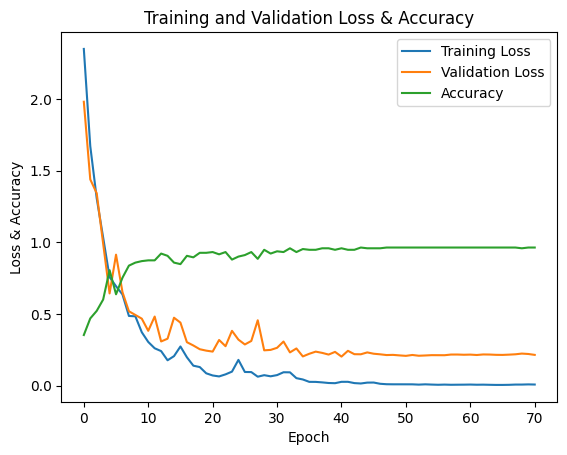

In [710]:
# 绘制曲线图
plt.figure()
plt.plot(eazy_train, label='Training Loss')

plt.plot(eazy_validation, label='Validation Loss')

plt.plot(eazy_accuracies, label='Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss & Accuracy')
plt.legend()
plt.show()

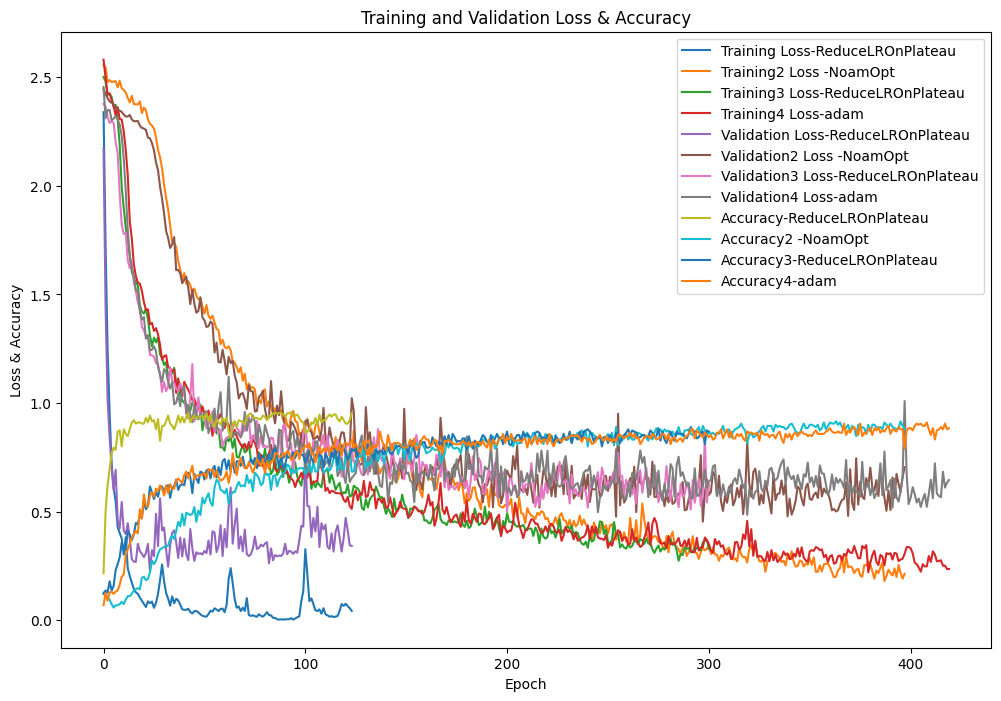

In [132]:
# 绘制曲线图
plt.figure(figsize=(12, 8))
plt.plot(eazy_train, label='Training Loss-ReduceLROnPlateau')
plt.plot(train2, label='Training2 Loss -NoamOpt')
plt.plot(train3, label='Training3 Loss-ReduceLROnPlateau')
plt.plot(train4, label='Training4 Loss-adam')
plt.plot(eazy_validation, label='Validation Loss-ReduceLROnPlateau')
plt.plot(validation2, label='Validation2 Loss -NoamOpt')
plt.plot(validation3, label='Validation3 Loss-ReduceLROnPlateau')
plt.plot(validation4, label='Validation4 Loss-adam')
plt.plot(eazy_accuracies, label='Accuracy-ReduceLROnPlateau')
plt.plot(accuracies2, label='Accuracy2 -NoamOpt')
plt.plot(accuracies3, label='Accuracy3-ReduceLROnPlateau')
plt.plot(accuracies4, label='Accuracy4-adam')

plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.title('Training and Validation Loss & Accuracy')
plt.legend()
plt.show()


In [58]:
torch.save(model.state_dict(), 'D:\helloworld\VT1\model_transformer\model1.pth')
loaded_model = TransformerModel(input_size, hidden_size, num_layers, output_size).to(device)
loaded_model.load_state_dict(torch.load('D:\helloworld\VT1\model_transformer\model1.pth'))
loaded_model.eval()

TransformerModel(
  (embedding): Linear(in_features=42, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (query): Linear(in_features=128, out_features=128, bias=True)
          (key): Linear(in_features=128, out_features=128, bias=True)
          (value): Linear(in_features=128, out_features=128, bias=True)
          (fc_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (query): Linear(in_features=128, out_fea

# 视频

In [352]:
# 初始化 MediaPipe Hands API
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

#gesture_names = ['back', 'front', 'left', 'right', 'stop', 'yeah', 'good', 'hello', 'ok', 'bad']

video_path = 'D:\\helloworld\\VT1\\test_video\\test.mp4'
output_path = 'D:\\helloworld\\VT1\\test_video\\test_val_tansformer.mp4'

cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)

probabilities_per_frame = {}
max_gesture_per_frame = {}
frame_steps = []



In [353]:
# 初始化 MediaPipe Hands 模型
with mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hand_model:
    frame_step = 0  # 初始化帧步数
    while cap.isOpened():  # 当视频文件可以正常打开时
        ret, frame = cap.read()  # 读取一帧
        if not ret:  # 如果读取失败，则退出循环
            break

        # 更新帧步数，并将其添加到列表中
        frame_step += 1
        frame_steps.append(frame_step)

        # 以下代码大部分与之前相同，除了将“second”替换为“frame_step”

        timestamp = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0  # 获取当前帧的时间戳（秒）
        second = math.floor(timestamp)  # 将时间戳向下取整，得到当前帧所在的秒数

        # 将帧的颜色空间从 BGR 转为 RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # 使用手部模型对图像进行处理
        result = hand_model.process(image)
        # 将图像的颜色空间转回 BGR，以便后续的显示和保存
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if result.multi_hand_landmarks:  # 如果在图像中检测到手部
            # 以下代码与之前相同，除了将“second”替换为“frame_step”

            landmarks = result.multi_hand_landmarks[0]  # 获取第一只检测到的手的标记点
            mp_drawing.draw_landmarks(frame, landmarks, mp_hands.HAND_CONNECTIONS)

            x, y = [], []
            for lm in landmarks.landmark:  # 遍历所有标记点
                x.append(lm.x)  # 保存标记点的 x 坐标
                y.append(lm.y)  # 保存标记点的 y 坐标

            points = np.asarray([x, y])
            min = points.min(axis=1, keepdims=True)
            max = points.max(axis=1, keepdims=True)
            normalized = np.stack((points - min) / (max - min), axis=1).flatten()

            keypoints = torch.tensor(normalized, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)
            with torch.no_grad():
                output = loaded_model(keypoints)
                probabilities = torch.softmax(output, dim=1)
                gesture = torch.argmax(probabilities, dim=1).item()

            confidence = probabilities.max().item()

            if frame_step not in max_gesture_per_frame or confidence > max_gesture_per_frame[frame_step][1]:
                max_gesture_per_frame[frame_step] = (gesture, confidence)

            # 使用 LabelEncoder 的 inverse_transform 方法将预测的标签编码转换回原始标签
            gesture_name = label_encoder.inverse_transform([gesture])[0]
            cv2.putText(frame, f'Gesture: {gesture_name}, Confidence: {confidence:.2f}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # 获取所有的类别名
            class_names = label_encoder.classes_

            # 定义起始位置
            start_x = 10
            start_y = 50

            # 遍历所有的类别名和对应的概率
            for i, (class_name, prob) in enumerate(zip(class_names, probabilities.squeeze().tolist())):
                color = (0, 255, 0)  # 默认为绿色
                if prob > 0.1:
                    color = (0, 0, 255)  # 红色
                text = f'{class_name}: {prob:.2f}'  # 使用class_name，而不是gesture_name[i]
                cv2.putText(frame, text, (start_x, start_y + i*30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

                                
        out.write(frame)

cap.release()
out.release()